In [216]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from network import solve_ode_network
from scipy.signal import hilbert, butter, filtfilt

In [217]:
def plot_x_values(x_values):
    j = np.array([0,20])
    fig, axes = plt.subplots(len(j), 1, figsize=(12, len(j)*3))

    for i in range(len(j)):
        axes[i].plot(x_values[:,j[i]], label=f'j={j[i]}')
        axes[i].set_xlabel('Time Steps')
        axes[i].set_ylabel(f'x_{j[i]}')
        axes[i].set_title(f'Solution of ODE for x_{j[i]}')
        axes[i].legend()

    plt.tight_layout()


In [218]:
mat = loadmat('../references/AAL78/C78.mat')
C = mat['C']

In [219]:
# Function to apply band-pass filter
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Function to apply low-pass filter
def lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


In [264]:
f = 12
num_steps = 1000  # total steps
dt = 0.01  # time step
a = 0.0  # intrinsic dynamics parameters for each neuron
omega = 2 * np.pi * f  # angular frequencies for each neuron
beta = 1000  # noise level
G = 0.5

# Filter parameters
fs = 1/dt
band_lowcut = f - 2
band_highcut = f + 2
lowpass_cutoff = 0.2

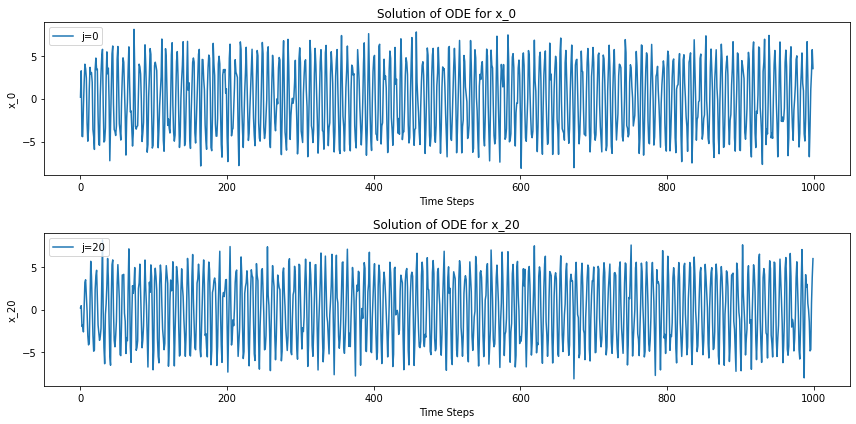

In [265]:
# Solve the ODEs
x_values, y_values = solve_ode_network(num_steps, dt, a, omega, beta, C, G)
plot_x_values(x_values)

In [266]:
# Preallocate arrays for filtered signals
filtered_x = np.zeros_like(x_values)
filtered_y = np.zeros_like(y_values)

# Band-pass filter for each region
for i in range(78):
    filtered_x[:, i] = bandpass_filter(x_values[:, i], band_lowcut, band_highcut, fs)
    filtered_y[:, i] = bandpass_filter(y_values[:, i], band_lowcut, band_highcut, fs)

# plot_x_values(filtered_x)

In [274]:
# Calculate the Hilbert transform to get the instantaneous amplitude
from scipy.signal import hilbert, hilbert2, savgol_filter, find_peaks
from scipy.interpolate import interp1d

analytical_x = hilbert(filtered_x)
amplitude_env_x = np.abs(analytical_x)

# analytical_y = hilbert(filtered_y)
# amplitude_env_y = np.abs(analytical_y)


ValueError: `x` must be a 1-D array

In [261]:
# Low-pass filter the amplitude envelope
ultra_slow_x = np.zeros_like(amplitude_env_x)
# ultra_slow_y = np.zeros_like(amplitude_env_y)
for i in range(78):
    ultra_slow_x[:, i] = lowpass_filter(amplitude_env_x[:, i], lowpass_cutoff, fs)
    # ultra_slow_y[:, i] = lowpass_filter(amplitude_env_y[:, i], lowpass_cutoff, fs)

In [285]:
def plot_signal_processing_stages(x_values, filtered_x, amplitude_env_x, ultra_slow_x):

    peaks, _ = find_peaks(amplitude_env_x)
    peak_interpolation = interp1d(peaks, amplitude_env_x[peaks], kind='linear', fill_value='extrapolate')
    smooth_outline = peak_interpolation(np.arange(len(filtered_x)))
    # Plot setup
    fig, axs = plt.subplots(4, 1, figsize=(12, 8))
    
    # Original signal
    axs[0].plot(x_values, label='Original Signal')
    axs[0].set_title('Original Signal')
    axs[0].set_ylabel('Amplitude')
    
    # Amplitude envelope
    axs[1].plot(amplitude_env_x, label='Amplitude Envelope', color='green')
    axs[1].set_title('Amplitude Envelope (Hilbert Transform)')
    axs[1].set_ylabel('Amplitude')
    # axs[1].legend()

    # Filtered signal
    axs[2].plot(filtered_x, label='Filtered Signal', color='orange')
    axs[2].plot(smooth_outline, label='Amplitude Envelope', color='green')
    axs[2].set_title('Band-Pass Filtered Signal')
    axs[2].set_ylabel('Amplitude')
    
    # Ultra-slow fluctuations
    axs[3].plot(ultra_slow_x, label='Ultra Slow Fluctuations', color='red')
    axs[3].set_title('Ultra-Slow Fluctuations of the Amplitude Envelope')
    axs[3].set_xlabel('Time (s)')
    axs[3].set_ylabel('Amplitude')

    # Determine unified y-axis limits for the first three plots
    all_values = np.concatenate([x_values, filtered_x])
    unified_ylim = [all_values.min(), all_values.max()]

    # Setting the same y-axis limits for the first three subplots
    axs[0].set_ylim(unified_ylim)
    axs[2].set_ylim(unified_ylim)

    # Adjusting layout and showing the plot
    plt.tight_layout()
    plt.show()

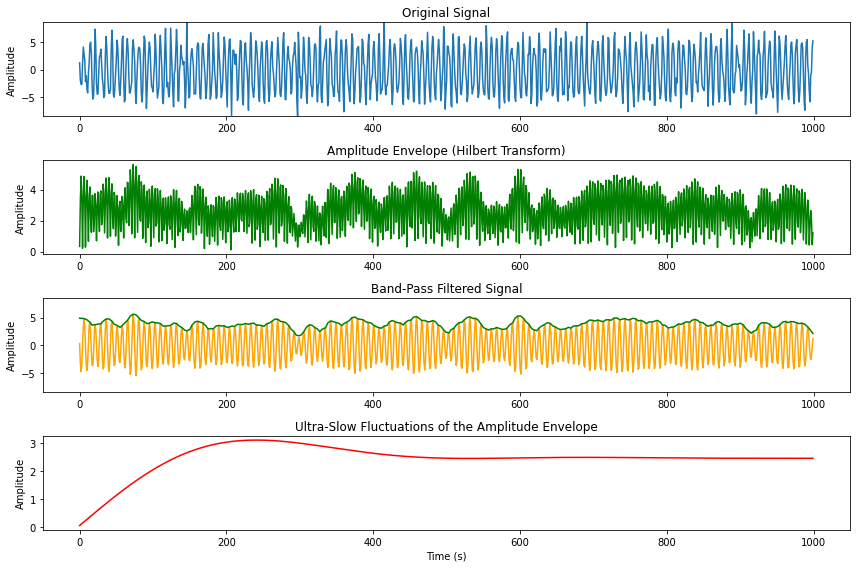

In [286]:
# def plot_for_index(index, )
index = 40
x = x_values[:,index]

band_pass_fil = filtered_x[:, index]
amplitude_env = amplitude_env_x[:, index]
ultra_slow = ultra_slow_x[:,index]
plot_signal_processing_stages(x, band_pass_fil, amplitude_env, ultra_slow)